In [1]:
import numpy as np
import pandas as pd
import os
from glob import glob
import matplotlib.pylab as plt
from tqdm import tqdm
from sklearn.cluster import KMeans
from Preprocessing2 import Signal_process, Stat_process 
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from icecream import ic 
from scipy import signal
import pickle
%matplotlib inline

In [2]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, MaxPooling1D, UpSampling2D,Conv2DTranspose, Flatten, Reshape, Concatenate, AveragePooling2D
from tensorflow.keras.layers import UpSampling2D,Conv2DTranspose, Flatten, Reshape, Concatenate, AveragePooling2D, MaxPooling1D, Conv1D, Conv1DTranspose
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization, Dropout, concatenate
from tensorflow.keras.backend import sigmoid
from tensorflow.keras.utils import get_custom_objects
from tensorflow import keras
from tensorflow.keras import callbacks as cb
from tensorflow.keras.layers import Input, GRU, Dense, Reshape, LSTM, RepeatVector, TimeDistributed

tf.random.set_seed(121)

# Load Data

In [3]:
path = 'D:/Data/CMAPSSData'

train_path_list = sorted(glob(path + '/train*'))
test_path_list = sorted(glob(path + '/test*'))
rul_path_list = sorted(glob(path + '/RUL*'))

In [4]:
col_name = ['unit number', 'time', 'op1', 'op2', 'op3']
temp = ['sensor %d'%(i+1) for i in range(23)]

load_col_name = col_name + temp
col_name = load_col_name[:-2]

In [5]:
train = []
for t_path in train_path_list:
    temp = pd.read_table(t_path, sep = ' ', header = None, names=load_col_name)
    train.append(temp[col_name])

test = []
for t_path in test_path_list:
    temp = pd.read_table(t_path, sep = ' ', header = None, names=load_col_name)
    test.append(temp[col_name])
    
RUL = []
for r_path in rul_path_list:
    temp = pd.read_table(r_path, header = None, names = ['RUL'])
    RUL.append(temp)

# Train, Test index seperate by unit number and time

In [6]:
train_index = []
for key, value in enumerate(train):
    train_index.append(train[key][['unit number', 'time']])
    train[key] = train[key].drop(['unit number', 'time'], axis = 1)
    
test_index = []
for key, value in enumerate(test):
    test_index.append(test[key][['unit number', 'time']])
    test[key] = test[key].drop(['unit number', 'time'], axis = 1)

# Data length save

In [7]:
unit_num_train = []
for D in train_index:
    unit_num_train.append(D.groupby('unit number').count().shape[0])
    
unit_num_test = []
for D in test_index:
    unit_num_test.append(D.groupby('unit number').count().shape[0])

In [8]:
label = []

for key, values in enumerate(unit_num_train):
    temp = []
    for i in range(values):
        index = train_index[key].groupby('unit number').get_group(i+1).index
        N = len(index)
        rul = np.linspace(0,1,N)
        temp.append(rul)
    temp = np.concatenate(temp)
    label.append(temp)

In [9]:
label_test = []

for key, values in enumerate(unit_num_test):
    temp = []
    for i in range(values):
        index = test_index[key].groupby('unit number').get_group(i+1).index
        N = len(index)
        rul = np.linspace(0,1,N)
        temp.append(rul)
    temp = np.concatenate(temp)
    label_test.append(temp)

# Scaler(optional)

In [10]:
#SCALE = 'None' # MINMAX, STANDARD

def NORM(TRAIN, SCALE):
    if SCALE == 'MINMAX':
        scaler_norm = []
        for key, values in enumerate(TRAIN):
            scaler_norm_ = MinMaxScaler().fit(values)
            scaler_norm.append(scaler_norm_)
            TRAIN[key] = scaler_norm_.transform(values)
            TRAIN[key] = pd.DataFrame(TRAIN[key], columns = col_name[2:])

    if SCALE == 'STANDARD':
        scaler_norm = []
        for key, values in enumerate(TRAIN):
            scaler_norm_ = StandardScaler().fit(values)
            scaler_norm.append(scaler_norm_)
            TRAIN[key] = scaler_norm_.transform(values)
            TRAIN[key] = pd.DataFrame(TRAIN[key], columns = col_name[2:])
    
    return TRAIN, scaler_norm

# feature selection process

In [11]:
minmax_train, scaler = NORM(train, 'MINMAX')

train_ = pd.concat([train_index[0], minmax_train[0]], axis = 1)
variance_check = train_.groupby('unit number').std()
bol = variance_check > 0.1
selected_idx = np.where(bol.sum(axis=0) == 100)[0] + 1
selected_col = [col_name[index] for index in selected_idx]
selected_col

['time',
 'op1',
 'op2',
 'sensor 2',
 'sensor 3',
 'sensor 4',
 'sensor 11',
 'sensor 15',
 'sensor 20',
 'sensor 21']

In [12]:
minmax_train[0] = minmax_train[0][selected_col[1:]]
minmax_train[1] = minmax_train[1][selected_col[1:]]
minmax_train[2] = minmax_train[2][selected_col[1:]]
minmax_train[3] = minmax_train[3][selected_col[1:]]

In [13]:
minmax_train[0]['RUL'] = label[0]
minmax_train[1]['RUL'] = label[1]
minmax_train[2]['RUL'] = label[2]
minmax_train[3]['RUL'] = label[3]

# test normalization & feature selection

In [14]:
for i in range(4):
    test[i] = scaler[i].transform(test[i])
    test[i] = pd.DataFrame(test[i], columns = col_name[2:])
    test[i] = test[i][selected_col[1:]]

In [15]:
test[0]['RUL'] = label_test[0]
test[1]['RUL'] = label_test[1]
test[2]['RUL'] = label_test[2]
test[3]['RUL'] = label_test[3]

# seperate train, val

In [16]:
train_ratio = 0.8
train_indices = []
validation_indices = []

for i in range(4):
    D = list(set(train_index[i]['unit number']))
    N = len(D)
    ratio = int(train_ratio * N)
    indices = np.random.permutation(D)
    train_idx, val_idx = indices[:ratio], indices[ratio:]
    
    train_indices.append(train_idx)
    validation_indices.append(val_idx)

In [17]:
def rolling_window(a, window, axis=0):
    """
         Return the array of the 2D array sliding window array
    """
    if axis == 0:
        shape = (a.shape[0] - window +1, window, a.shape[-1])
        strides = (a.strides[0],) + a.strides
        a_rolling = np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)
    elif axis==1:
        shape = (a.shape[-1] - window +1,) + (a.shape[0], window) 
        strides = (a.strides[-1],) + a.strides
        a_rolling = np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)
    return a_rolling

In [104]:
'''수정중 완료 - train_index 만들었음, 
train_index_visu도 나중에 만들어야함
'''
window_len = 20
X = []
train_INDEX_ = []
for key, values in enumerate(train_indices):
    temp = []
    index_temp = []
    for i in values:
        index = train_index[key].groupby('unit number').get_group(i).index
        D = minmax_train[key].loc[index]
        win_gen = rolling_window(D.values, window_len)        
        index_temp.append(win_gen.shape[0])
        temp.append(win_gen)
    temp = np.concatenate(temp)
    index_temp = np.array(index_temp)
    train_INDEX_.append(index_temp)
    X.append(temp)

In [35]:
# window_len = 20
# X = []
# for key, values in enumerate(train_indices):
#     temp = []
#     index_temp = []
#     for i in values:
#         index = train_index[key].groupby('unit number').get_group(i).index
#         D = minmax_train[key].loc[index]
#         win_gen = rolling_window(D.values, window_len)
#         temp.append(win_gen)
#     temp = np.concatenate(temp)
#     X.append(temp)

In [ ]:
'''수정중 - val_index 만들어야함'''
# window_len = 20
# X_val = []
# val_INDEX = []
# for key, values in enumerate(validation_indices):
#     temp = []
#     for i in values:
#         index = train_index[key].groupby('unit number').get_group(i).index
#         D = minmax_train[key].loc[index]
#         win_gen = rolling_window(D.values, window_len)
#         temp.append(win_gen)

#     temp = np.concatenate(temp)
#     X_val.append(temp)

In [19]:
window_len = 20
X_val = []
for key, values in enumerate(validation_indices):
    temp = []
    for i in values:
        index = train_index[key].groupby('unit number').get_group(i).index
        D = minmax_train[key].loc[index]
        win_gen = rolling_window(D.values, window_len)
        temp.append(win_gen)

    temp = np.concatenate(temp)
    X_val.append(temp)

In [20]:
x_train = np.concatenate(X)[:,:,:-1].copy()
y_train = np.concatenate(X)[:,-1,-1].copy()

x_val = np.concatenate(X_val)[:,:,:-1].copy()
y_val = np.concatenate(X_val)[:,-1,-1].copy()

In [105]:
'''test index 만드는 중'''
window_len = 20
X_test = []
test_INDEX_ = []
for key, values in enumerate(test):
    temp = []
    index_temp = []
    for i in range(unit_num_test[key]):
        index = test_index[key].groupby('unit number').get_group(i+1).index
        D = test[key].loc[index]
        win_gen = rolling_window(D.values, window_len)
        index_temp.append(win_gen.shape[0])
        temp.append(win_gen)
    temp = np.concatenate(temp)
    index_temp = np.array(index_temp)
    X_test.append(temp)
    test_INDEX_.append(index_temp)

In [21]:
# window_len = 20
# X_test = []
# INDEX_test = []
# for key, values in enumerate(test):
#     temp = []
#     for i in range(unit_num_test[key]):
#         index = test_index[key].groupby('unit number').get_group(i+1).index
#         INDEX_test.append(len(index))
#         D = test[key].loc[index]
#         win_gen = rolling_window(D.values, window_len)
#         temp.append(win_gen)

#     temp = np.concatenate(temp)
#     X_test.append(temp)

In [22]:
x_test = np.concatenate(X_test)[:,:,:-1].copy()
y_test = np.concatenate(X_test)[:,-1,-1].copy()

In [23]:
def FEAE():
    signal_inputs = Input(shape=(20,9), name = 'signal_inputs')
    x = GRU(20, return_sequences=True)(signal_inputs)
    x = LSTM(20, return_sequences=False)(x)
    latent = Dense(10, name = 'latent')(x)
    x = Dense(20)(latent)
    x = RepeatVector(20)(x)
    #x = TimeDistributed(20)(x0)
    x = LSTM(9, return_sequences=True, name = 'signal_AE')(x)
    
    
    rul_inputs = Dense(10, activation = 'relu')(latent)
    h = Dense(5, activation = 'tanh')(rul_inputs)
    h = Dense(1, activation = 'linear', name = 'RUL_OUTPUT')(h)
    
    
    model = Model(signal_inputs, [x,h])
    return model

In [24]:
model = FEAE()
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
signal_inputs (InputLayer)      [(None, 20, 9)]      0                                            
__________________________________________________________________________________________________
gru (GRU)                       (None, 20, 20)       1860        signal_inputs[0][0]              
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 20)           3280        gru[0][0]                        
__________________________________________________________________________________________________
latent (Dense)                  (None, 10)           210         lstm[0][0]                       
_______________________________________________________________________________________

In [25]:
model.compile(optimizer = keras.optimizers.Adam(lr = 0.00001), loss = 'mse')
model_path = 'C:/Users/BISTel/PycharmProjects/bistel/model_weight/'
model.load_weights(model_path + 'lstm_feae.hdf5')

In [57]:
# import time
# start = time.time()

# reduce_lr = cb.ReduceLROnPlateau(monitor='val_loss', factor=0.5, min_lr=1e-6,
#                                  patience=5, cooldown=25, min_delta=0, verbose=1)

# early_stop = cb.EarlyStopping(monitor='val_loss', patience=8, min_delta=0)

# callbacks = [early_stop, reduce_lr]


# hist = model.fit(x = x_train,
#                  y = {'signal_AE':x_train,
#                       'RUL_OUTPUT':y_train},
#                  validation_data = (x_val, [x_val, y_val]),
#                        epochs = 2000,
#                        batch_size = 256,
#                        callbacks=callbacks)

# #combination.save_weights(MODEL_SAVE_DIR_PATH + 'last_version.hdf5')

Epoch 1/2000
458/458 [==============================] - 12s 17ms/step - loss: 0.5725 - signal_AE_loss: 0.3373 - RUL_OUTPUT_loss: 0.2352 - val_loss: 0.4398 - val_signal_AE_loss: 0.3225 - val_RUL_OUTPUT_loss: 0.1172
Epoch 2/2000
458/458 [==============================] - 7s 16ms/step - loss: 0.4189 - signal_AE_loss: 0.3185 - RUL_OUTPUT_loss: 0.1005 - val_loss: 0.3613 - val_signal_AE_loss: 0.2902 - val_RUL_OUTPUT_loss: 0.0711
Epoch 3/2000
458/458 [==============================] - 7s 16ms/step - loss: 0.3527 - signal_AE_loss: 0.2827 - RUL_OUTPUT_loss: 0.0700 - val_loss: 0.3161 - val_signal_AE_loss: 0.2493 - val_RUL_OUTPUT_loss: 0.0668
Epoch 4/2000
458/458 [==============================] - 7s 15ms/step - loss: 0.3091 - signal_AE_loss: 0.2415 - RUL_OUTPUT_loss: 0.0676 - val_loss: 0.2740 - val_signal_AE_loss: 0.2076 - val_RUL_OUTPUT_loss: 0.0663
Epoch 5/2000
458/458 [==============================] - 7s 15ms/step - loss: 0.2673 - signal_AE_loss: 0.2002 - RUL_OUTPUT_loss: 0.0671 - val_loss: 

In [108]:
train_HI = model.predict(x_train)[1]
test_HI = model.predict(x_test)[1]

In [43]:
train_HI.shape

(117742, 1)

In [106]:
train_INDEX = np.insert(np.cumsum(np.concatenate(train_INDEX_)), 0, 0)
test_INDEX = np.insert(np.cumsum(np.concatenate(test_INDEX_)), 0, 0)

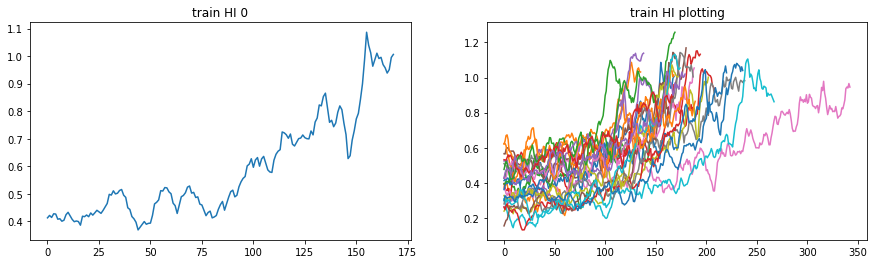

In [149]:
k = 0
before = train_INDEX[k]
after = train_INDEX[k+1]
fig, ax = plt.subplots(1,2, figsize = (15,4))
ax[0].plot(train_HI[before:after])
ax[0].set_title(f'train HI {k}')

for i in range(25):
    before = train_INDEX[i]
    after = train_INDEX[i+1]
    ax[1].plot(train_HI[before:after])
ax[1].set_title(f'train HI plotting')
plt.show()

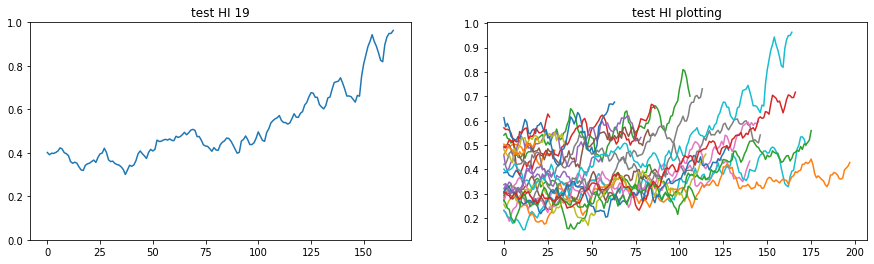

In [152]:
k = 19
before = test_INDEX[k]
after = test_INDEX[k+1]

fig, ax = plt.subplots(1,2,figsize = (15,4))
ax[0].plot(test_HI[before:after])
ax[0].set_title(f'test HI {k}')
ax[0].set_ylim(0,1)

for i in range(25):
    before = test_INDEX[i]
    after = test_INDEX[i+1]
    ax[1].plot(test_HI[before:after])
ax[1].set_title(f"test HI plotting")
plt.show()

In [157]:
rul_label = np.concatenate(RUL)
rul_label = rul_label.flatten()

In [238]:
from sklearn.linear_model import LinearRegression
import math
def RUL_PREDICTION(k, observ):
    #k = 490
    #observ = 20

    before = test_INDEX[k]
    after = test_INDEX[k+1]
    print(f'total length: {after - before}')
    '''
    error handling
    1. observation값보다 데이터 길이가 적을 경우.

    2. 
    '''

    linear_reg_y = test_HI[before:after][-observ:]
    linear_reg_x = np.arange(observ).reshape(-1,1)

    reg = LinearRegression().fit(linear_reg_x, linear_reg_y)
    reg.score(linear_reg_x, linear_reg_y)
    A, B = reg.coef_, reg.intercept_

    print(f'A: {A}, B: {B}')
    if A < 0:
        print(f"Estimated RUL: {linear_reg_x[-1]/linear_reg_y[-1] - linear_reg_x[-1]}")
    else:
        print(f"Estimated RUL: {(1-B)/A - 20}")
    print(f'true RUL: {rul_label[k]}')
    print(f'error: {(1-B)/A - 20  - rul_label[k]}')
    need_x = math.ceil((1-B)/A)
    #plt.plot(linear_reg_y)
    plt.scatter(linear_reg_x, linear_reg_y) # prediction 결과
    if A < 0:
        plt.scatter(linear_reg_x[-1]/linear_reg_y[-1], 1, marker = '*', s = 150, color = 'black')
    else:
        plt.plot((A*np.arange(need_x)+B).flatten(), 'black') # prediction observation 기준으로 linear regression
        plt.axvline(np.arange(need_x)[-1], ymin = 0, ymax = 0.95)
    plt.scatter(linear_reg_x[-1]+rul_label[k], 1, s = 100, marker = '*', color = 'r') # 실제 RUL scattering
    plt.axhline(1, color = 'r', linewidth = 2)
    plt.axvline(linear_reg_x[-1]+rul_label[k], ymax = 0.95)
    #plt.axvline(np.arange(need_x)[-1], ymin = 0, ymax = 0.95)
    plt.show()

In [239]:
'''여기 위에 함수 코드 있음'''

'여기 위에 함수 코드 있음'

total length: 126
A: [[0.00971611]], B: [0.3521492]
Estimated RUL: [[46.6779967]]
true RUL: 48
error: [[-1.3220033]]


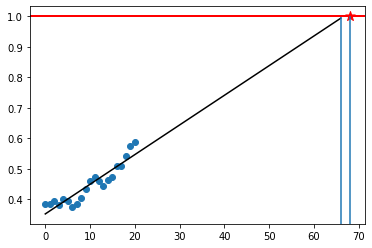

In [267]:
RUL_PREDICTION(k=31, observ = 21)

In [237]:
'''여기 밑에 코드있음'''

'여기 밑에 코드있음'

total length: 241
A: [[0.00569731]], B: [0.81356133]
Estimated RUL: [[12.72398577]]
true RUL: 22
error: [[-9.27601423]]


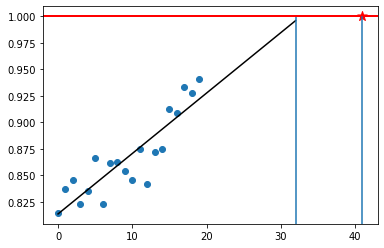

In [236]:
from sklearn.linear_model import LinearRegression
import math
k = 490
observ = 20

before = test_INDEX[k]
after = test_INDEX[k+1]
print(f'total length: {after - before}')
'''
error handling
1. observation값보다 데이터 길이가 적을 경우.

2. 
'''

linear_reg_y = test_HI[before:after][-observ:]
linear_reg_x = np.arange(observ).reshape(-1,1)

reg = LinearRegression().fit(linear_reg_x, linear_reg_y)
reg.score(linear_reg_x, linear_reg_y)
A, B = reg.coef_, reg.intercept_

print(f'A: {A}, B: {B}')
if A < 0:
    print(f"Estimated RUL: {linear_reg_x[-1]/linear_reg_y[-1] - linear_reg_x[-1]}")
else:
    print(f"Estimated RUL: {(1-B)/A - 20}")
print(f'true RUL: {rul_label[k]}')
print(f'error: {(1-B)/A - 20  - rul_label[k]}')
need_x = math.ceil((1-B)/A)
#plt.plot(linear_reg_y)
plt.scatter(linear_reg_x, linear_reg_y) # prediction 결과
if A < 0:
    plt.scatter(linear_reg_x[-1]/linear_reg_y[-1], 1, marker = '*', s = 150, color = 'black')
else:
    plt.plot((A*np.arange(need_x)+B).flatten(), 'black') # prediction observation 기준으로 linear regression
    plt.axvline(np.arange(need_x)[-1], ymin = 0, ymax = 0.95)
plt.scatter(linear_reg_x[-1]+rul_label[k], 1, s = 100, marker = '*', color = 'r') # 실제 RUL scattering
plt.axhline(1, color = 'r', linewidth = 2)
plt.axvline(linear_reg_x[-1]+rul_label[k], ymax = 0.95)
#plt.axvline(np.arange(need_x)[-1], ymin = 0, ymax = 0.95)
plt.show()

[[27.46170767]]
RUL    15
Name: 4, dtype: int64


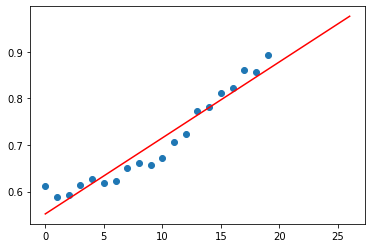

In [228]:
from sklearn.linear_model import LinearRegression
k = 104
observ = 20

linear_reg_y = pre_test[pre_test_index[k]:pre_test_index[k+1]][-observ:]
linear_reg_x = np.arange(observ).reshape(-1,1)

reg = LinearRegression().fit(linear_reg_x, linear_reg_y)
reg.score(linear_reg_x, linear_reg_y)
A, B = reg.coef_, reg.intercept_
print((1-B)/A)
print(RUL[1].loc[k-100])

need_x = int((1-B)/A)
#plt.plot(linear_reg_y)
plt.scatter(linear_reg_x, linear_reg_y)
plt.plot((A*np.arange(need_x)+B).flatten(), 'r')
plt.show()

In [119]:
signal_AE = Model(model.get_layer('signal_inputs').input, model.get_layer('signal_AE').output)
signal_Encoder = Model(model.get_layer('signal_inputs').input, model.get_layer('dense_20').output)

In [137]:
# MODEL_SAVE_DIR_PATH = 'C:/Users/HYKP/PycharmProjects/bistel/CMAPSS/model_weight/'
# model.save_weights(MODEL_SAVE_DIR_PATH + 'lstm_feae.hdf5')

In [269]:
def scoring_function(error):
    if error>=0:
        s=np.exp(error/10)-1
        return s
    else:
        s=np.exp(-error/13)-1
        return s